In [1]:
import pandas as pd
import numpy as np

In [20]:
df = pd.read_csv(r"train_clean.csv")
kaggle_pred = pd.read_csv(r"test_clean.csv")

In [21]:
df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

#convert true and false in Embarked to binary
df["Embarked_C"] = df["Embarked_C"].astype(int)
df["Embarked_S"] = df["Embarked_S"].astype(int)

In [22]:
df.Survived.value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

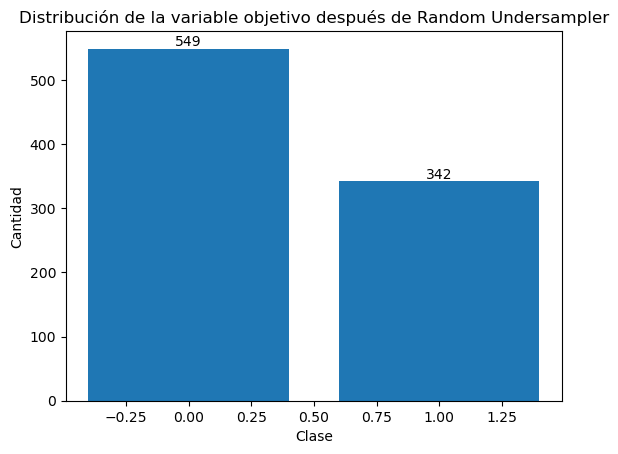

In [23]:
import matplotlib.pyplot as plt

# Datos de la distribución después de aplicar Random Undersampler
clases = [0, 1]
cantidad = [549, 342]

# Crear gráfico de barras
plt.bar(clases, cantidad)

# Agregar etiquetas de conteo en las barras
for i in range(len(clases)):
    plt.text(clases[i], cantidad[i], str(cantidad[i]), ha='center', va='bottom')

# Etiquetas y título del gráfico
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.title('Distribución de la variable objetivo después de Random Undersampler')

# Mostrar el gráfico
plt.show()

### Resampling techniques

Como vemos que hay un pequeño imbalance en las clases vamos a explorar algunas tecnicas de resampling para mejorar la prediccion de la clase minoritaria.

In [24]:
from sklearn.model_selection import train_test_split

# slpit df in train and test
X_train, X_test, y_train, y_test = train_test_split(df.drop('Survived', axis = 1), df['Survived'], test_size=0.2, random_state=77)

In [25]:
### Oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [27]:
### SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

In [32]:
y_resampled.value_counts()

Survived
1    426
0    426
Name: count, dtype: int64

In [33]:
#### Grid Search
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, classification_report

# Definimos param_grid para ajustar el modelo a 200 árboles y profundidad máx de 10
param_grid_rf = {'n_estimators': [200, 400], 'max_depth': [5, 10, 15], 'min_samples_split': [2, 10], 'min_samples_leaf': [1, 4], 'min_impurity_decrease': [0.0, 0.1, 0.2], 'class_weight': ['balanced'], 
                'bootstrap' : [True, False], 'criterion': ['gini', 'entropy']} #max_features opcional (probar luego de ajustar los demás hiperparámetros)

#{'n_estimators': [200, 400], 'max_depth': [5, 10, 15], 'min_samples_split': [2, 10], 'min_samples_leaf': [1, 4]}

#param_grid_rf = { 'n_estimators': [100, 200, 300], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 4, 6], 
#                'min_samples_leaf': [1, 2, 3], 'max_features': ['auto', 'sqrt', 'log2']}

kfold = StratifiedKFold(n_splits=5, random_state=77, shuffle=True)

# Creamos el modelo
rf = RandomForestClassifier(random_state=0, n_jobs=-1)

# Definimos el objeto 'scorer' para ajustar automáticamente los hiperparámetros de un modelo usando GridSearchCV 
#scorer = make_scorer(accuracy_score)

# Definimos el GridSearchCV para el modelo RandomForestClassifier
grid_search_rf = GridSearchCV(rf, param_grid_rf, scoring='f1_macro', cv=kfold)

# Ajustamos GridSearchCV a los datos remuestreados
grid_search_rf.fit(X_resampled, y_resampled)

# Obtenemos el mejor estimador para el modelo RandomForestClassifier
best_rf = grid_search_rf.best_estimator_
best_rf

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=15, min_samples_leaf=4,
                       min_samples_split=10, n_estimators=200, n_jobs=-1,
                       random_state=0)

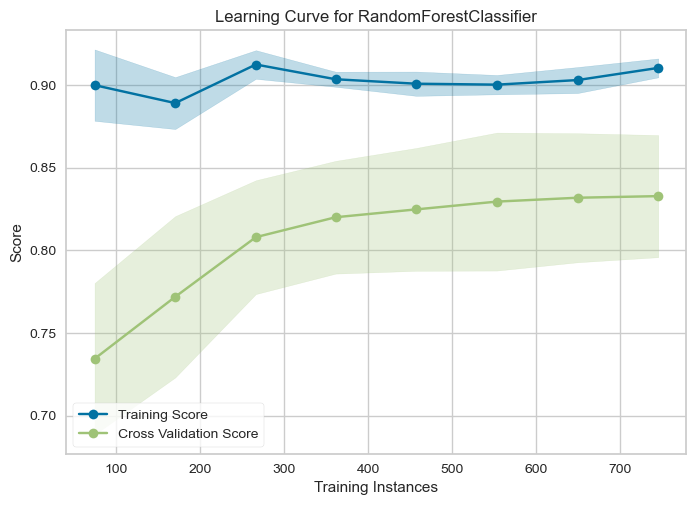

<AxesSubplot:title={'center':'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [34]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
from yellowbrick.model_selection import LearningCurve


# Fit the model
best_rf.fit(X_resampled, y_resampled)

# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=8, random_state=77, shuffle=True)
sizes = np.linspace(0.1, 1.0, 8)

visualizer = LearningCurve(
    best_rf, cv=cv, scoring=make_scorer(f1_score, average='macro'), train_sizes=sizes, n_jobs=-1
)

# Fit the training data to the visualizer
visualizer.fit(X_resampled, y_resampled)

# Finalize and render the learning curve
visualizer.show()

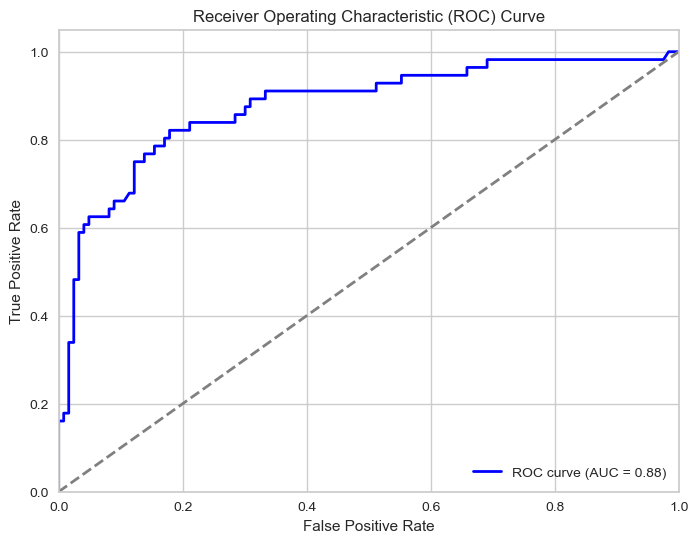

In [35]:

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_prob = best_rf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [38]:

#sin class weights

# Realizamos las predicciones en el conjunto de prueba
y_pred_rf = best_rf.predict(X_test)

# Generamos el informe de clasificación
classification_report_rf = classification_report(y_test, y_pred_rf)
print("Random Forest Classifier Classification Report:")
print(classification_report_rf)

#confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Random Forest Classifier Confusion Matrix:")
print(confusion_matrix_rf)

Random Forest Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       123
           1       0.68      0.79      0.73        56

    accuracy                           0.82       179
   macro avg       0.79      0.81      0.79       179
weighted avg       0.83      0.82      0.82       179

Random Forest Classifier Confusion Matrix:
[[102  21]
 [ 12  44]]


In [39]:
## demas pruebas (ignorar)
#### optuna
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
from yellowbrick.model_selection import LearningCurve
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
    max_depth = trial.suggest_int('max_depth', 2, 16, step=2)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=77
    )
    clf.fit(X_resampled, y_resampled)

    y_pred_optuna = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred_optuna, average='macro')
    return f1

In [40]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print('Best Hyperparameters:', study.best_params)
print('Best Accuracy:', study.best_value)
best_params = study.best_params

[I 2023-08-17 10:33:00,021] A new study created in memory with name: no-name-6bde5052-5858-4f94-a775-dad50611c108


[I 2023-08-17 10:33:00,783] Trial 0 finished with value: 0.8087061840980336 and parameters: {'n_estimators': 300, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8087061840980336.
[I 2023-08-17 10:33:01,019] Trial 1 finished with value: 0.7671319573854647 and parameters: {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8087061840980336.
[I 2023-08-17 10:33:02,314] Trial 2 finished with value: 0.781532238379189 and parameters: {'n_estimators': 600, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.8087061840980336.
[I 2023-08-17 10:33:04,582] Trial 3 finished with value: 0.804894342674308 and parameters: {'n_estimators': 1000, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8087061840980336.
[I 2023-08-17 10:33:06,020] Trial 4 finished with value: 0.8103813559322034 and parameters: {'n_

Best Hyperparameters: {'n_estimators': 600, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 4}
Best Accuracy: 0.8189838546570423


In [41]:
best_rf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=77
)
best_rf.fit(X_resampled, y_resampled)

y_pred = best_rf.predict(X_test)
#best_params = study.best_params

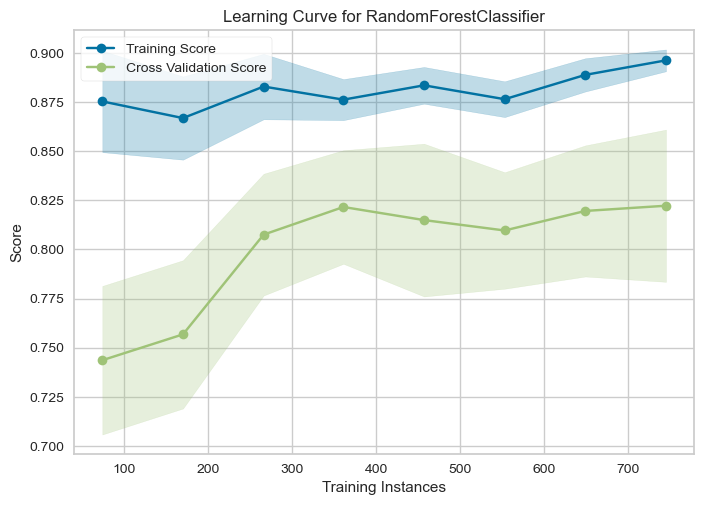

<AxesSubplot:title={'center':'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [42]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
from yellowbrick.model_selection import LearningCurve


# Fit the model
best_rf.fit(X_resampled, y_resampled)

# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=8, random_state=77, shuffle=True)
sizes = np.linspace(0.1, 1.0, 8)

visualizer = LearningCurve(
    best_rf, cv=cv, scoring=make_scorer(f1_score, average='macro'), train_sizes=sizes, n_jobs=-1
)

# Fit the training data to the visualizer
visualizer.fit(X_resampled, y_resampled)

# Finalize and render the learning curve
visualizer.show()

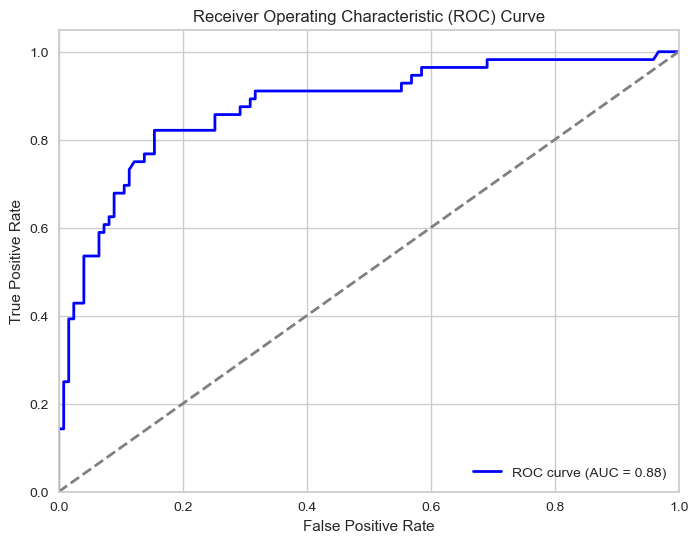

In [43]:

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_prob = best_rf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [44]:

#sin class weights

# Realizamos las predicciones en el conjunto de prueba
y_pred_rf = best_rf.predict(X_test)

# Generamos el informe de clasificación
classification_report_rf = classification_report(y_test, y_pred_rf)
print("Random Forest Classifier Classification Report:")
print(classification_report_rf)

#confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Random Forest Classifier Confusion Matrix:")
print(confusion_matrix_rf)

Random Forest Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       123
           1       0.71      0.82      0.76        56

    accuracy                           0.84       179
   macro avg       0.81      0.83      0.82       179
weighted avg       0.85      0.84      0.84       179

Random Forest Classifier Confusion Matrix:
[[104  19]
 [ 10  46]]


c:\Users\Alfre\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


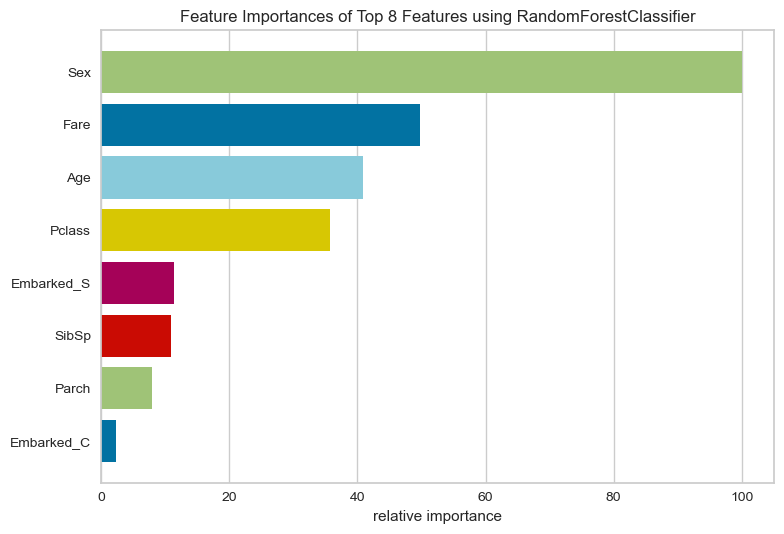

<AxesSubplot:title={'center':'Feature Importances of Top 8 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [47]:
import yellowbrick
from yellowbrick.model_selection import FeatureImportances
feature_names = X_train.columns

viz = FeatureImportances(best_rf, labels=feature_names, topn=8)

viz.fit(X_resampled, y_resampled)

viz.show(feature=20)